In [2]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel


In [3]:
%pip install datasets==2.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 3.2.0
    Uninstalling datasets-3.2.0:
      Successfully uninstalled datasets-3.2.0
Note: you may need to restart the kernel to use updated packages.


In [7]:
from datasets import load_dataset

train_dataset = load_dataset("bentrevett/multi30k", split="train")
test_dataset = load_dataset("bentrevett/multi30k", split="test")

In [8]:
def filter_dataset(dataset, minlen: int, maxlen: int) -> list[dict[str, str]]:
    return [
        dataset[i]["en"]
        for i in range(len(dataset))
        if len(dataset[i]["en"].split(" ")) <= maxlen and len(dataset[i]["en"].split(" "))>=minlen
    ]

In [9]:
maxlen = 30
minlen = 5
train_filtered = filter_dataset(train_dataset, minlen, maxlen)
test_filtered = filter_dataset(test_dataset, minlen, maxlen)
print(len(train_filtered), len(test_filtered))

28945 997


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [12]:
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
bert_model = BertModel.from_pretrained("prajjwal1/bert-tiny").to(device)
embedding_matrix = bert_model.embeddings.word_embeddings.weight
embedding_matrix.shape

torch.Size([30522, 128])

In [13]:
def collate_fn(
    tokenizer: AutoTokenizer, batch: list[tuple[str, str]]
) -> tuple[Tensor, Tensor]:
    encoded_batch = tokenizer.batch_encode_plus(
        batch, padding="longest", return_tensors="pt", return_attention_mask=False)['input_ids']
  
    return encoded_batch

In [14]:
train_loader = DataLoader(train_filtered, batch_size=32, shuffle=True, collate_fn=lambda batch:collate_fn(tokenizer,batch))
test_loader = DataLoader(test_filtered, batch_size=32, shuffle=True, collate_fn=lambda batch:collate_fn(tokenizer,batch))
tokens = next(iter(train_loader)).to(device)

In [15]:
#LSTM архитектура с bidirectional encoder
class sentence_auto_encoder(nn.Module):
  def __init__(self, vocab_size, hidden_dim:int=512, pretrained_emb_matrix: Tensor = embedding_matrix)-> None:
    super().__init__()
    self.embed = nn.Embedding.from_pretrained(pretrained_emb_matrix, freeze=True)
    self.encoder = nn.LSTM(input_size=pretrained_emb_matrix.size(1), hidden_size=hidden_dim, bidirectional=True,num_layers=1, batch_first=True)
    self.l = nn.Linear(hidden_dim*2, hidden_dim*2)
    self.dropout = nn.Dropout(0.2)
    self.decoder = nn.LSTM(input_size=hidden_dim*2, hidden_size=hidden_dim*2, num_layers=1, batch_first=True)
    self.lm_head = nn.Linear(hidden_dim*2, vocab_size)
      
  def forward(self, x: Tensor)-> Tensor:
    
    x = self.embed(x)
    l, (_, _) = self.encoder(x) # BxTxS
    sentence_emb = l[:,-1] #берём последний выход rnn
    B, S = sentence_emb.shape
    decoder_input = self.dropout(F.tanh(self.l(sentence_emb)))
    
    decoder_input=decoder_input.unsqueeze(1).expand((B, x.size(1), S))
    lstm_out, (hn, cn) = self.decoder(decoder_input)

    lstm_out_reshaped = lstm_out.contiguous().view(-1, S) 
    linear_out = self.lm_head(lstm_out_reshaped)
    final_output = linear_out.contiguous().view(B, x.size(1), -1) 
    return final_output, sentence_emb 
    # с sentence_emb будем сравнивать эмбедлинги предложений,
    #полученные из encoder для сгенрированных emb tokens


In [17]:
tokens.shape

torch.Size([32, 26])

In [16]:
def generate(probs, n_samples=10):
  data = []
  for i in range(n_samples):
    p = (-torch.log(-torch.log(torch.rand(probs.shape,device=device))))
    T = 0.5
    alpha = F.softmax((p+torch.log(probs))/T, dim=-1)
    data.append(torch.matmul(alpha, embedding_matrix))

  res = torch.stack(data,0)
  return res

In [17]:
#оптимизуруем cos_sim между sent_emb1, sent_emb2,
#полученные из encoder для tokens и сгенерированных emb из выхода 
def paraphrase_loss(n_samples, logits, sent_emb, encoder):
  probs = F.softmax(logits, dim=-1)
  gen_samples = generate(probs,n_samples)
  gen_sent_emd = []
  for sample in gen_samples:
    l, (_, _) = encoder(sample) # BxTxS
    gen_sent_emd.append(l[:,-1]) 
  gen_sent_emd  = torch.stack(gen_sent_emd,0)
  loss = torch.tensor(1,device=device)-(F.normalize(gen_sent_emd, dim=-1)*F.normalize(sent_emb, dim=-1)).sum(-1).mean()
  return loss

In [18]:
autoencoder = sentence_auto_encoder(vocab_size=len(tokenizer)).to(device)
logits,sent_emb = autoencoder.forward(tokens)
paraphrase_loss(10,logits,sent_emb,autoencoder.encoder)

tensor(0.1038, device='cuda:0', grad_fn=<SubBackward0>)

In [19]:
import copy

In [20]:
def train_epoch(dataloader: DataLoader,model: nn.Module,optimizer: torch.optim.Optimizer):
    model.train()
    loss_total = 0
    n_total = 0
    n_correct = 0

    for tokens in dataloader:
        tokens = tokens.to(device)
        logits,sent_emb = model(tokens)

        entropy_loss = F.cross_entropy(
            logits.reshape(-1, len(tokenizer)),
            tokens.reshape(-1),
        )

        #копируя, encoder получает градиент только от logits, без копирования ещё от прохода сгенерированных emb tokens
        copy_encoder = copy.deepcopy(model.encoder)
        loss =  entropy_loss+paraphrase_loss(5,logits,sent_emb,copy_encoder)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        b_size = tokens.size(0)*tokens.size(1)
        n_total += b_size
        loss_total +=  b_size*loss.item()
        n_correct += (tokens == logits.argmax(dim=-1)).sum().item()

    loss=loss_total / n_total
    acc = n_correct / n_total

    train_loss.append(loss)
    train_acc.append(acc)

In [21]:
@torch.no_grad()
def test_epoch(dataloader: DataLoader,model: nn.Module):
    model.eval()
    loss_total = 0
    n_total = 0
    n_correct = 0

    for tokens in dataloader:
        tokens = tokens.to(device)
        logits,sent_emb = model(tokens)

        entropy_loss = F.cross_entropy(
            logits.reshape(-1, len(tokenizer)),
            tokens.reshape(-1),
        )

        loss =  entropy_loss+paraphrase_loss(5,logits,sent_emb,model.encoder)
        b_size = tokens.size(0)*tokens.size(1)
        n_total += b_size
        loss_total +=  b_size*loss.item()
        n_correct += (tokens == logits.argmax(dim=-1)).sum().item()

    loss=loss_total / n_total
    acc = n_correct / n_total

    val_loss.append(loss)
    val_acc.append(acc)

In [24]:
torch.manual_seed(42)
model = sentence_auto_encoder(vocab_size=len(tokenizer)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
EPOCHS = 10
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}")
    train_epoch(train_loader,model,optimizer)
    test_epoch(test_loader,model)
    print(f"Train_loss={train_loss[-1]}, Val_loss={val_loss[-1]}")
    print(f"Train_accuracy={train_acc[-1]}, Val_accuracy={val_acc[-1]}")

EPOCH 0
Train_loss=3.4334764725797204, Val_loss=2.836917787126833
Train_accuracy=0.49646806036618757, Val_accuracy=0.5274342253204407
EPOCH 1
Train_loss=2.7977312392746243, Val_loss=2.64387885706569
Train_accuracy=0.5608900811432408, Val_accuracy=0.5788812532328382
EPOCH 2
Train_loss=2.6930672270852805, Val_loss=2.6031134928083794
Train_accuracy=0.5818903479099024, Val_accuracy=0.5988109572546658
EPOCH 3
Train_loss=2.659833890839122, Val_loss=2.5791038579097902
Train_accuracy=0.583905297111057, Val_accuracy=0.5991561181434599
EPOCH 4
Train_loss=2.6230132912166213, Val_loss=2.564000787401804
Train_accuracy=0.5901224029864923, Val_accuracy=0.603437253205972
EPOCH 5
Train_loss=2.612508348789557, Val_loss=2.570828264101359
Train_accuracy=0.5912287185039062, Val_accuracy=0.5965766508108918
EPOCH 6
Train_loss=2.594669507246175, Val_loss=2.5146757096645938
Train_accuracy=0.5934478670364437, Val_accuracy=0.6091715207954588
EPOCH 7
Train_loss=2.5916774523263606, Val_loss=2.5560884417489205
Trai

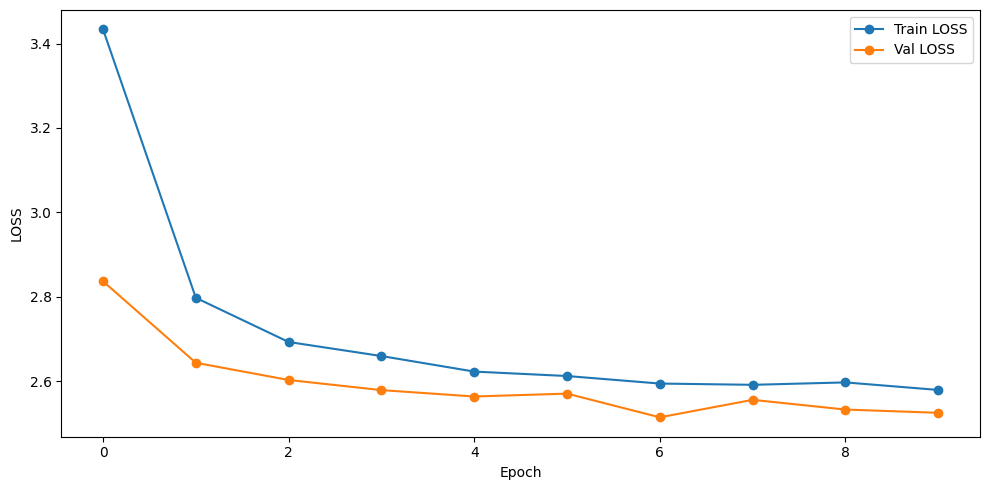

In [27]:
import matplotlib.pyplot as plt

def grafics(train_acc, val_acc, conf):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label=f"Train {conf}", marker='o')
    plt.plot(val_acc, label=f"Val {conf}", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel(conf)
    plt.legend()
    plt.tight_layout()
    plt.show()

grafics(train_loss,val_loss, "LOSS")

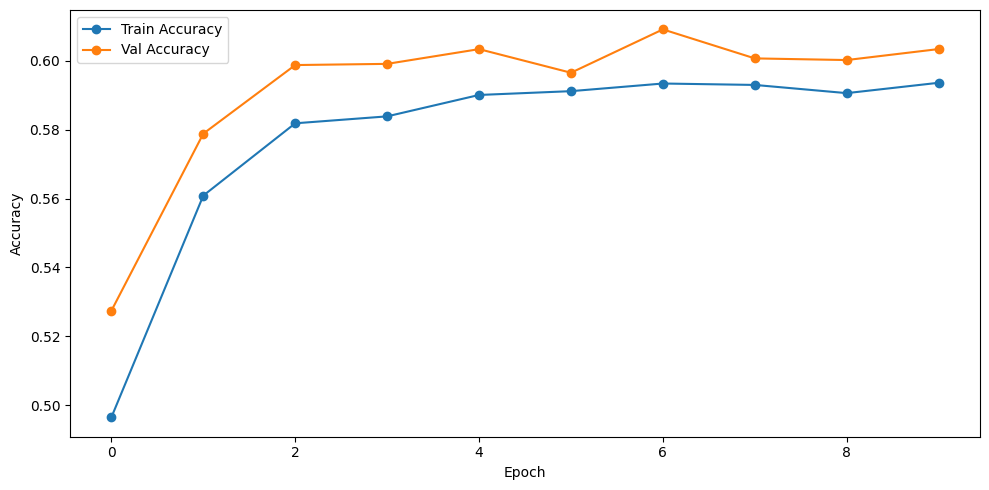

In [26]:
grafics(train_acc,val_acc, "Accuracy")